In [1]:
%matplotlib inline
from __future__ import print_function, division, absolute_import
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import display
import seaborn as sns
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")

## Read in Megan Bedell's x-matched GAIA DR2-Kepler stellar catalog

from <a href="gaia-kepler.fun">gaia-kepler.fun</a>.

In [2]:
from astropy.table import Table
kepler_dr2 = Table.read('kepler_dr2_1arcsec.fits', format='fits')
df1 = kepler_dr2.to_pandas()

In [3]:
print(np.array(df1.columns))
print(len(df1))

['designation' 'source_id' 'gaia_ref_epoch' 'ra' 'ra_error' 'dec'
 'dec_error' 'parallax' 'parallax_error' 'parallax_over_error' 'pmra'
 'pmra_error' 'pmdec' 'pmdec_error' 'ra_dec_corr' 'ra_parallax_corr'
 'ra_pmra_corr' 'ra_pmdec_corr' 'dec_parallax_corr' 'dec_pmra_corr'
 'dec_pmdec_corr' 'parallax_pmra_corr' 'parallax_pmdec_corr'
 'pmra_pmdec_corr' 'astrometric_chi2_al' 'astrometric_excess_noise'
 'astrometric_excess_noise_sig' 'astrometric_primary_flag'
 'duplicated_source' 'phot_g_mean_flux' 'phot_g_mean_flux_error'
 'phot_g_mean_mag' 'phot_bp_mean_flux' 'phot_bp_mean_flux_error'
 'phot_bp_mean_mag' 'phot_rp_mean_flux' 'phot_rp_mean_flux_error'
 'phot_rp_mean_mag' 'bp_rp' 'bp_g' 'g_rp' 'radial_velocity'
 'radial_velocity_error' 'phot_variable_flag' 'l' 'b' 'ecl_lon' 'ecl_lat'
 'teff_val' 'teff_percentile_lower' 'teff_percentile_upper' 'a_g_val'
 'a_g_percentile_lower' 'a_g_percentile_upper' 'e_bp_min_rp_val'
 'e_bp_min_rp_percentile_lower' 'e_bp_min_rp_percentile_upper'
 'radius_va

## Read in McQuillan et al. (2014) catalog of Kepler rotation periods

from Vizier

In [4]:
kepler_prot = Table.read('J_ApJS_211_24_t1.fits', format='fits', hdu=1)
df2 = kepler_prot.to_pandas()

In [5]:
print(np.array(df2.columns))
print(len(df2))

['KIC' 'Teff' 'log_g_' 'Mass' 'Prot' 'e_Prot' 'n_Prot' 'Rper' 'LPH' 'w'
 'Ref' '_RA' '_DE']
34030


## Merge the two

Use left join to keep all entries in the GAIA-Kepler x-match for now

In [6]:
df=df1.merge(df2, how='left', left_on='kepid', right_on='KIC')
print(len(df))

197090


remove rows with no entries in McQuillan catalog, or missing proper motions, or missing distances

In [7]:
df=df.dropna(subset=['Prot','pmra','pmdec','r_est'])
print(len(df))

33853


## Remove duplicates

for now keep closest match only - may not be the right one of course. Thanks Oli Hall for the function.

In [8]:
def kill_duplicates(df,ID, sep):
    '''A function that kills duplciates in a pandas dataframe on a given separation column.
    Input:
        df (pandas dataframe): A pandas dataframe of the data you want to kill duplicates for.
        
        ID (str): The label of the ID column (i.e. KIC, 2MASS). This is used to find the duplicates.
        
        sep (str): The label of the separation column. This is used to cut the duplicates.
        
    Returns:
        df (pandas dataframe): The input pandas dataframe with duplicates killed.
    '''
    df = df.copy(deep=True)
    sel = df.duplicated(ID, keep=False)
    s = df[sel]
    for idx in range(s[ID].nunique()):
        subset = s[s[ID] == s[ID].values[idx]]
        lock = True  #Iterate and remove the target of largest separation
        while lock:
            if len(subset) > 1.:
                drop = subset[sep].idxmax()
                subset.drop(drop, inplace=True)
                s.drop(drop,inplace=True)
                df.drop(drop, inplace=True)
            elif len(subset == 1.):
                lock = False
            else:
                print('The code shouldnt be here?')
    return df

In [9]:
df = kill_duplicates(df,'source_id','kepler_gaia_ang_dist')
print(len(df))

/Users/aigrain/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/aigrain/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


33808


## Compute total proper motion, and from that tangential velocity


In [48]:
df['pmtot'] = np.sqrt(df['pmra']**2 + df['pmdec']**2)
au2km = 149597870.700
yr2s = 3600.0*24*365.25
df['vtan'] = df['pmtot'] * df['r_est'] * au2km / yr2s / 1e3
print(len(df))
print(np.array(df['vtan'])[:10])

33808
[ 6.87433931 12.35686057 44.32641163 49.1159771  16.6366702  10.08354551
 47.70973521 12.48204093 13.77686016 38.47330134]


## Compute distance modulus, and from that absolute G-mag

In [12]:
mu = 5 * np.log10(df['r_est']) - 5
df['M_G'] = df['phot_g_mean_mag'] - mu #- df['a_g_val']
df.dropna(subset=['pmtot','vel','M_G'])
print(len(df))

33808


## Select stars within 1000 pc

In [33]:
l1 = df['r_est'] <= 500
l2 = df['r_est'] <= 1000

## Select single MS stars in GAIA HR diagram


Using 1 Gyr Dartmouth solar metallicity isochrone (alpha enhancement = 0)

In [18]:
import pandas as pd
names=['EEP','M/Mo','LogTeff','LogG','LogL/Lo','Gaia_G','Gaia_BP','Gaia_RP']
t = pd.read_table('fehp0ae0.iso',delim_whitespace=True,comment='#',header=None,names=names)
print(np.array(t.columns))
print(len(t))
l = (t['M/Mo'] < 1.7) * (t['M/Mo'] > 0.4)
t = t[l]
print(len(t))

['EEP' 'M/Mo' 'LogTeff' 'LogG' 'LogL/Lo' 'Gaia_G' 'Gaia_BP' 'Gaia_RP']
270
44


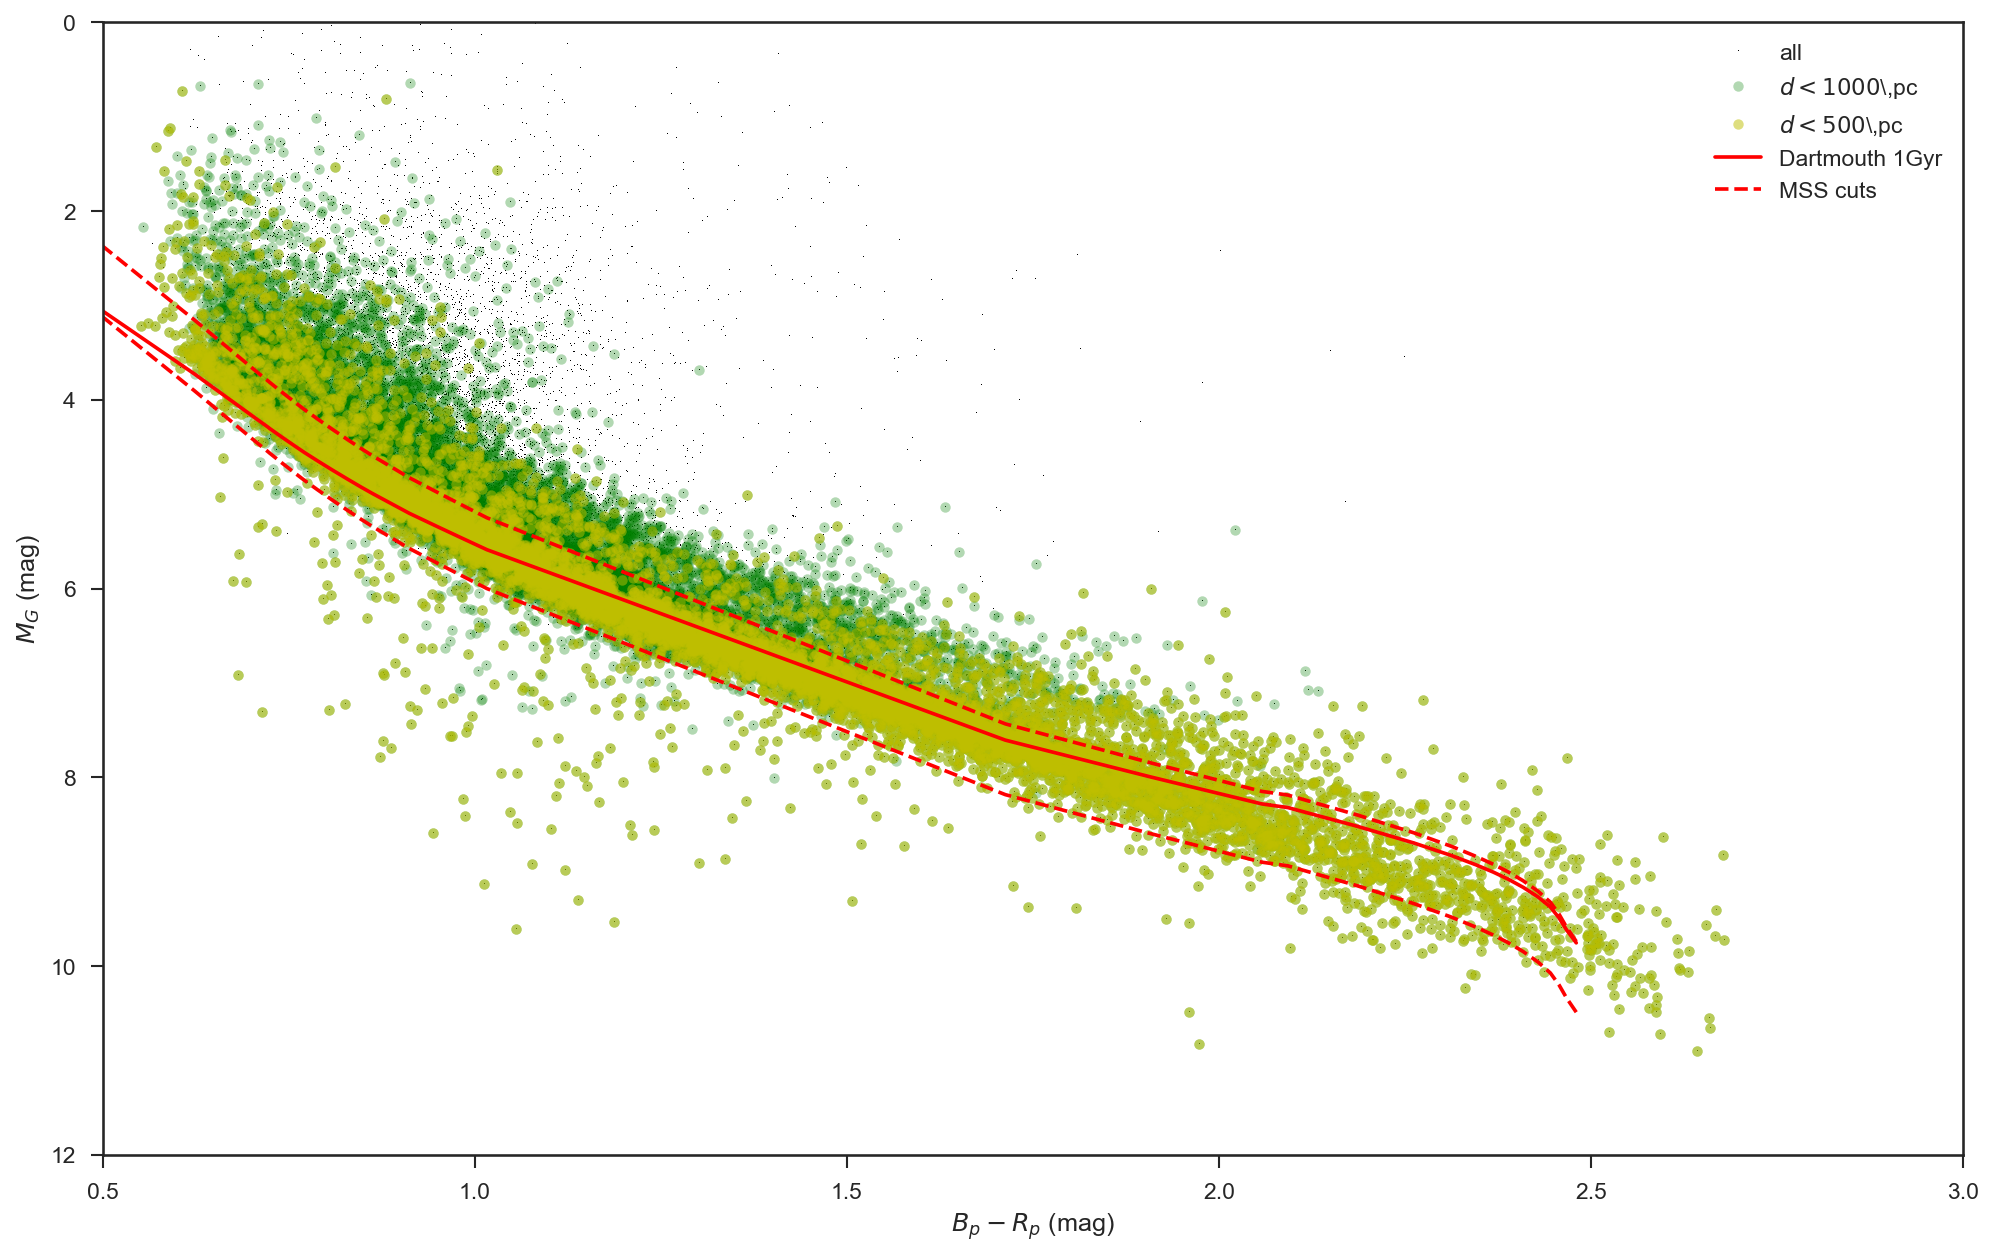

In [42]:
import matplotlib
matplotlib.rcParams["savefig.dpi"] = 150.0
matplotlib.rcParams["figure.dpi"] = 150.0
plt.figure(figsize=(16,10))
x = np.array(df['bp_rp']).flatten()
y = np.array(df['M_G']).flatten()
c = np.array(df['Prot']).flatten()
plt.plot(x, y, 'k,',label='all')
plt.plot(x[l2], y[l2], 'g.',ms=10,alpha=.3,label=r'$d<1000$ pc')
plt.plot(x[l1], y[l1], 'y.',ms=10,alpha=0.5,label=r'$d<500$ pc')
plt.plot(t['Gaia_BP']-t['Gaia_RP'],t['Gaia_G'],'r-',label='Dartmouth 1Gyr')
plt.plot(t['Gaia_BP']-t['Gaia_RP'],t['Gaia_G']-0.7*(t['M/Mo']-0.4),'r--',label='MSS cuts')
plt.plot(t['Gaia_BP']-t['Gaia_RP'],t['Gaia_G']-0.7*(t['M/Mo']-0.4)+0.75,'r--')
plt.xlim(0.5,3)
plt.ylim(12,0)
plt.legend(loc=0)
plt.xlabel(r'$B_p-R_p$ (mag)')
plt.ylabel(r'$M_G$ (mag)');

In [43]:
from scipy.interpolate import interp1d
bprp_cut = t['Gaia_BP'][l]-t['Gaia_RP'][l]
g_cut = t['Gaia_G'][l]-0.7*(t['M/Mo'][l]-0.4)
g = interp1d(bprp_cut,g_cut,bounds_error=False)
MSS = (df['M_G'] >= g(df['bp_rp'])) * (df['M_G'] <= (g(df['bp_rp']) + 0.75))
print(MSS.sum(),(MSS*l1).sum(),(MSS*l2).sum())

18322 6798 16537


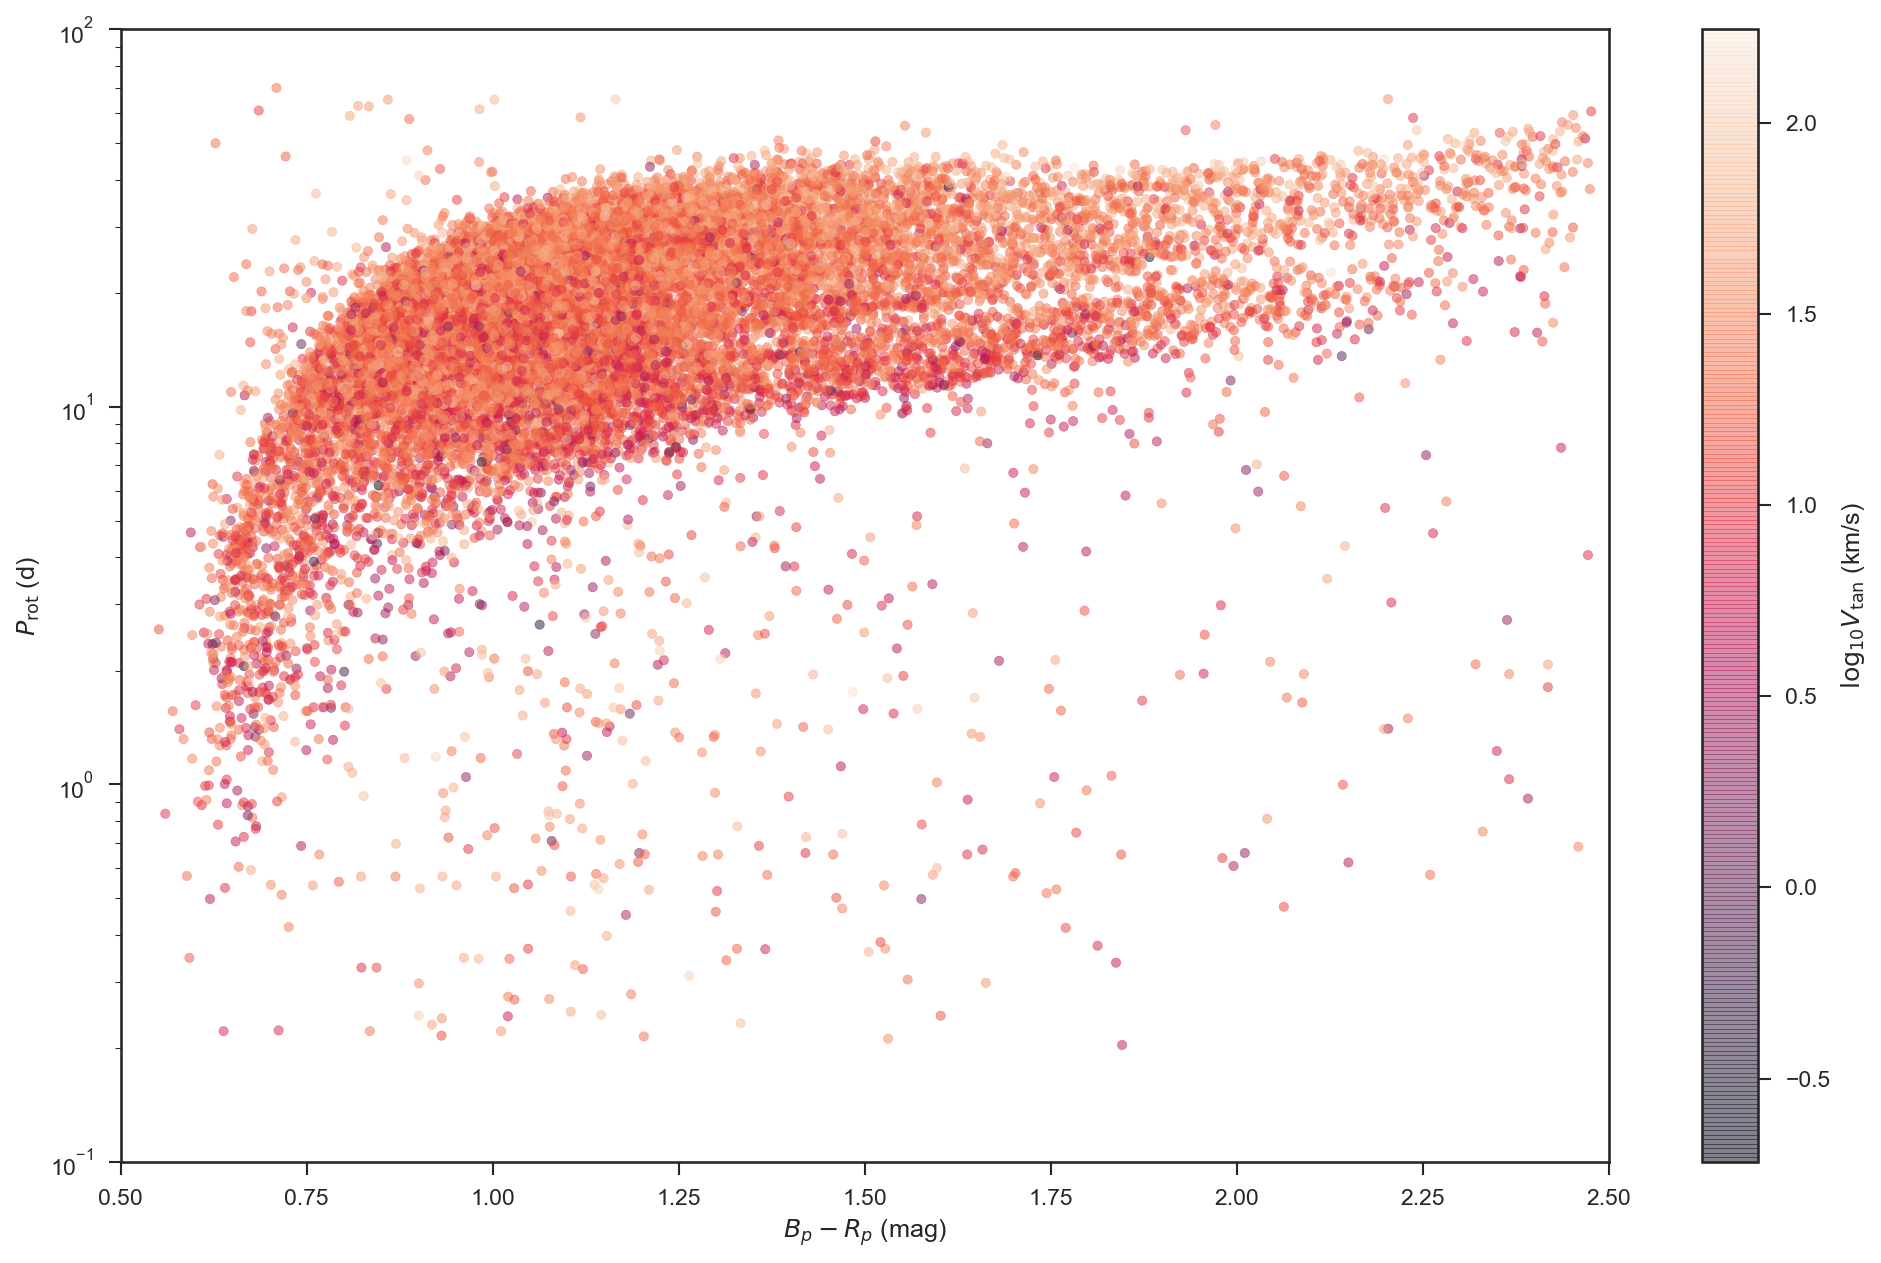

In [49]:
plt.figure(figsize=(16,10))
x = np.array(df['bp_rp']).flatten()
y = np.array(df['Prot']).flatten()
c = np.log10(np.array(df['vtan']).flatten())
plt.scatter(x[MSS], y[MSS], s = 20, c = c[MSS], alpha=0.5)
plt.colorbar(label='$\log_{10} V_{\mathrm{tan}}$ (km/s)')
plt.semilogy()
plt.xlim(0.5,2.5)
plt.ylim(0.1,100)
plt.legend(loc=0)
plt.xlabel(r'$B_p-R_p$ (mag)')
plt.ylabel(r'$P_{\mathrm{rot}}$ (d)');

In [ ]:
plt.figure(figsize=(10,10))
x = np.array(dfc['teff']).flatten()
y = np.array(dfc['Prot']).flatten()
c = np.log10(np.array(dfc['vel']).flatten())
plt.scatter(x, y, c = c, s=20,alpha=0.5)
plt.semilogy()
cb = plt.colorbar(label=r'$\log_{10} V_{\mathrm{tan}}$ (AU/yr)')
plt.xlim(6500,3500)
plt.title('all stars')
plt.xlabel(r'$T_{\mathrm{eff}}$ (K)')
plt.ylabel(r'$P_{\mathrm{rot}}$ (d)');`

l=(df['r_est']<500)
dfc = df[l]
print(len(dfc))